In [7]:
import warnings
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Dropout,Concatenate, BatchNormalization, SeparableConv2D
from tensorflow.keras.layers import Activation, MaxPooling2D, AveragePooling2D, Dense, concatenate, GlobalAveragePooling2D


SEED = 65
IMG_SIZE = 512,512
BATCH_SIZE = 8
AUTO = tf.data.AUTOTUNE

In [8]:
masks_folder = '/content/drive/MyDrive/Kvasir-SEG/masks'
converted_masks_folder = '/content/drive/MyDrive/converted_masks'
images_folder = '/content/drive/MyDrive/Kvasir-SEG/images'
converted_images_folder = '/content/drive/MyDrive/converted_images'

In [9]:
def convert_binary_masks(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)

    for mask_file in tqdm(os.listdir(input_folder)):
        if mask_file.endswith('.jpg'):
            mask_path = os.path.join(input_folder, mask_file)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            # Convert to binary mask
            _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

            # Save the binary mask
            output_path = os.path.join(output_folder, mask_file)
            cv2.imwrite(output_path, binary_mask)


In [10]:
def image_cvt_histeq_smooth(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)

    for image_file in tqdm(os.listdir(input_folder)):
        if image_file.endswith('.jpg'):
            image_path = os.path.join(input_folder, image_file)
            image = cv2.imread(image_path)

            # Convert to grayscale
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # Apply histogram equalization
            equ = cv2.equalizeHist(gray)

            # Apply Gaussian smoothing
            smoothed = cv2.GaussianBlur(equ, (3, 3), 0)

            # Save the processed image
            output_path = os.path.join(output_folder, image_file)
            cv2.imwrite(output_path, smoothed)

In [11]:
convert_binary_masks(masks_folder, converted_masks_folder)

# Apply histogram equalization and smoothing to images
image_cvt_histeq_smooth(images_folder, converted_images_folder)

100%|██████████| 1000/1000 [05:57<00:00,  2.80it/s]


In [12]:
from tqdm import tqdm

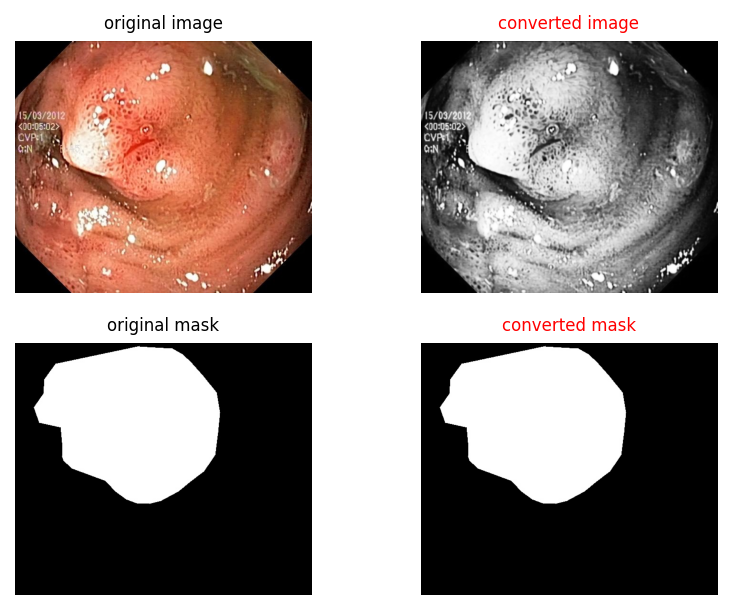

In [13]:
img_original = cv2.imread('/content/drive/MyDrive/Kvasir-SEG/images/cju0qkwl35piu0993l0dewei2.jpg')
img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)

mask_original = cv2.imread('/content/drive/MyDrive/Kvasir-SEG/masks/cju0qkwl35piu0993l0dewei2.jpg')

img_converted = cv2.imread('/content/drive/MyDrive/converted_images/cju0qkwl35piu0993l0dewei2.jpg')
mask_converted = cv2.imread('/content/drive/MyDrive/converted_masks/cju0qkwl35piu0993l0dewei2.jpg')

fig, ax = plt.subplots(2, 2, dpi=150)
ax[0][0].imshow(img_original)
ax[0][0].set_title('original image', fontsize=8)
ax[0][0].axis('off')

ax[0][1].imshow(img_converted)
ax[0][1].set_title('converted image', fontsize=8, color='red')
ax[0][1].axis('off')

ax[1][0].imshow(mask_original)
ax[1][0].set_title('original mask', fontsize=8)
ax[1][0].axis('off')

ax[1][1].imshow(mask_converted)
ax[1][1].set_title('converted mask', fontsize=8, color='red')
ax[1][1].axis('off')

plt.show()

In [14]:
import os
import pandas as pd
from sklearn.utils import shuffle

def create_images_list(path):
    full_path = []
    images = sorted(os.listdir(path))

    for i in images:
        full_path.append(os.path.join(path, i))

    return full_path

# Update the paths according to the Colab file structure
images_path = '/content/drive/MyDrive/converted_images'  # Update with the correct path
masks_path = '/content/drive/MyDrive/converted_masks'    # Update with the correct path

images = create_images_list(images_path)
masks = create_images_list(masks_path)

full_data = pd.DataFrame({'image': images, 'mask': masks})

# Shuffle the dataframe
full_data = shuffle(full_data).reset_index().drop(columns=['index'])


In [15]:
X_data, X_test, y_data, y_test = train_test_split(full_data['image'], full_data['mask'], test_size = 0.1, random_state = SEED)
X_train, X_validation, y_train, y_validation = train_test_split(X_data, y_data, test_size = 0.15, random_state = SEED + 1)

print("X_train shape -> ", X_data.shape)
print("X_val shape -> ", X_validation.shape)
print("X_test shape -> ", X_test.shape)

X_train shape ->  (900,)
X_val shape ->  (135,)
X_test shape ->  (100,)


In [16]:
def img_preprocessing(image, mask):
    img = tf.io.read_file(image)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0

    mask = tf.io.read_file(mask)
    mask = tf.io.decode_jpeg(mask, channels = 1)
    mask = tf.image.resize(mask, size = (IMG_SIZE))
    mask = tf.cast(mask, tf.float32) / 255.0

    return img, mask


In [17]:
train_loader = tf.data.Dataset.from_tensor_slices((X_data, y_data))
train_dataset = (train_loader
                 .map(img_preprocessing, num_parallel_calls = AUTO)
                 .batch(BATCH_SIZE)
                 .shuffle(X_data.shape[0])
                 .prefetch(AUTO))


validation_loader = tf.data.Dataset.from_tensor_slices((X_validation, y_validation))
validation_dataset = (validation_loader
                      .map(img_preprocessing, num_parallel_calls = AUTO)
                      .batch(BATCH_SIZE)
                      .prefetch(AUTO))


test_loader = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = (test_loader
                .map(img_preprocessing, num_parallel_calls = AUTO)
                .batch(BATCH_SIZE)
                .prefetch(AUTO))

In [18]:
class ConvBlock(Layer):
    def __init__(self, filters, kernel_size, dilation_rate, batch = False, padding = 'same', activation = 'relu', use_bias = False, **kwargs):
        super(ConvBlock, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.dilation_rate = dilation_rate
        self.batch = batch
        self.padding = padding
        self.activation = activation
        self.use_bias = use_bias

        self.conv = Conv2D(filters, kernel_size = kernel_size, dilation_rate = dilation_rate, padding = padding, use_bias = use_bias, kernel_initializer = 'he_normal')
        self.norm = BatchNormalization()
        self.act = Activation(activation)

    def call(self, inputs):
        X = self.conv(inputs)
        if self.batch:
            X = self.norm(X)
            X = self.act(X)
            return X
        else:
            X = self.act(X)
            return X


    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters" : self.filters,
            "kernel_size" : self.kernel_size,
            "dilation_rate" : self.dilation_rate,
            "activation" : self.act,
            "batch" : self.batch }

In [19]:
class DilatedSpatialPyramidPooling(Layer):
    def __init__(self, input_layer, kernel_1, kernel_2, kernel_3, kernel_4, dil1, dil2, dil3, dil4, **kwargs):
        super(DilatedSpatialPyramidPooling, self).__init__(**kwargs)
        self.input_layer = input_layer
        self.kernel_1 = kernel_1
        self.kernel_2 = kernel_2
        self.kernel_3 = kernel_3
        self.kernel_4 = kernel_4
        self.dil1 = dil1
        self.dil2 = dil2
        self.dil3 = dil3
        self.dil4 = dil4

        self.pool = AveragePooling2D(pool_size = (input_layer.shape[-3], input_layer.shape[-2]))
        self.convblock = ConvBlock(filters = 256, kernel_size=1, dilation_rate=1, batch = True, use_bias=True)
        self.outpool = UpSampling2D(size=(32,32), interpolation="bilinear")
        self.convout1 = ConvBlock(filters = 256, kernel_size = kernel_1, dilation_rate = dil1, batch = True)
        self.convout2 = ConvBlock(filters = 256, kernel_size = kernel_2, dilation_rate = dil2, batch = True)
        self.convout3 = ConvBlock(filters = 256, kernel_size = kernel_3, dilation_rate = dil3, batch = True)
        self.convout4 = ConvBlock(filters = 256, kernel_size = kernel_4, dilation_rate = dil4, batch = True)
        self.outconv = ConvBlock(filters = 256, kernel_size = 1, dilation_rate=1, batch = True)


    def call(self, inputs):
        X = self.pool(inputs)
        X = self.convblock(X)
        X_p = self.outpool(X)
        X_1 = self.convout1(inputs)
        X_2 = self.convout2(inputs)
        X_3 = self.convout3(inputs)
        X_4 = self.convout4(inputs)

        C = concatenate([X_p, X_1, X_2, X_3, X_4], axis = -1)
        X = self.outconv(C)
        return X


    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "input_layer": self.input_layer,
            "kernel_1" : self.kernel_1,
            "kernel_2" : self.kernel_2,
            "kernel_3" : self.kernel_3,
            "kernel_4" : self.kernel_4,
            "dil1" : self.dil1,
            "dil2" : self.dil2,
            "dil3" : self.dil3,
            "dil4" : self.dil4}

In [20]:
# Creating Dice and Jaccard metrics

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2 * intersection+1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def jaccard(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    jaccard = intersection  / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1e-6 )
    return jaccard

In [21]:
class PredictDuringTraining(Callback):
    def on_epoch_end(self, epochs, logs = None ):

        if (epochs + 1) % 1 == 0:
            samples = list(test_dataset.take(-1))

            idxs = np.random.permutation(X_test.shape[0])[0]
            batch_idx = idxs // BATCH_SIZE
            image_idx = idxs-batch_idx * BATCH_SIZE
            idx = idxs

            image = samples[batch_idx][0][image_idx]
            mask = samples[batch_idx][1][image_idx]

            pred_mask = self.model.predict(image[np.newaxis,...], verbose = 0)
            pred_ = np.squeeze(pred_mask)
            threshold  = 0.3
            bitmap_pred = (pred_ > threshold).astype(np.uint8)

            fig, axs = plt.subplots(1,3, figsize = (5,2) ,dpi = 120)
            fig.suptitle( 'epoch no :' + str(epochs + 1)  + ' ,images no :' + str(idx) , color='red', fontsize = 8 )

            axs[0].imshow(image , cmap = 'gray')
            axs[0].axis('off')
            axs[0].set_title('original image', fontsize = 6)

            axs[1].imshow(mask, cmap = 'gray')
            axs[1].axis('off')
            axs[1].set_title('original mask', fontsize = 6)
            axs[2].imshow( bitmap_pred, cmap = 'gray')
            axs[2].axis('off')
            axs[2].set_title('predict mask', fontsize = 6)

            plt.tight_layout()
            plt.show()
        else:
            pass

In [22]:
inp = Input(shape = (*IMG_SIZE ,3))
pretrained = ResNet50(weights="imagenet", include_top=False, input_tensor=inp)
X = pretrained.get_layer("conv4_block6_2_relu").output
X = DilatedSpatialPyramidPooling(X, kernel_1 = 1, kernel_2 = 3, kernel_3 = 3, kernel_4 = 3,
                                 dil1 = 1, dil2 = 6, dil3 = 12, dil4 = 18)(X)

X_1 = UpSampling2D(size = (IMG_SIZE[0] // 4 // X.shape[1], IMG_SIZE[0] // 4 // X.shape[2]), interpolation="bilinear")(X)

X_2 = pretrained.get_layer("conv2_block3_2_relu").output
X_2 = ConvBlock(filters=48, kernel_size=1, dilation_rate =1)(X_2)

X = Concatenate(axis=-1)([X_1, X_2])
X = ConvBlock(filters = 256, kernel_size = 3, dilation_rate = 1)(X)
X = ConvBlock(filters = 256, kernel_size = 3, dilation_rate = 1)(X)
X = UpSampling2D(size = (IMG_SIZE[0] // X.shape[1], IMG_SIZE[0] // X.shape[2]), interpolation="bilinear")(X)

out = Conv2D(1, 1 ,activation ='sigmoid', padding = 'same')(X)

model = Model(inputs = inp, outputs = out)
#model.summary()
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'binary_crossentropy' , metrics = [dice_coef_loss, dice_coef, jaccard])
my_callbacks = [PredictDuringTraining()]

94765736/94765736 [==============================] - 0s 0us/step


Epoch 1/15
113/113 [==============================] - ETA: 0s - loss: 0.3856 - dice_coef_loss: 0.6973 - dice_coef: 0.3027 - jaccard: 0.1801

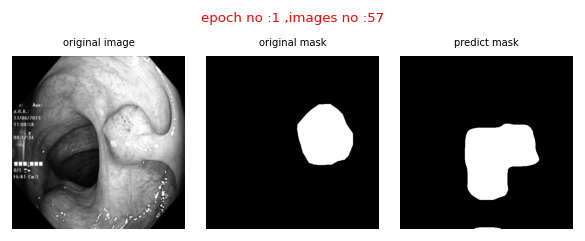

113/113 [==============================] - 143s 782ms/step - loss: 0.3856 - dice_coef_loss: 0.6973 - dice_coef: 0.3027 - jaccard: 0.1801 - val_loss: 0.3703 - val_dice_coef_loss: 0.7656 - val_dice_coef: 0.2344 - val_jaccard: 0.1333
Epoch 2/15
113/113 [==============================] - ETA: 0s - loss: 0.3106 - dice_coef_loss: 0.6378 - dice_coef: 0.3622 - jaccard: 0.2225

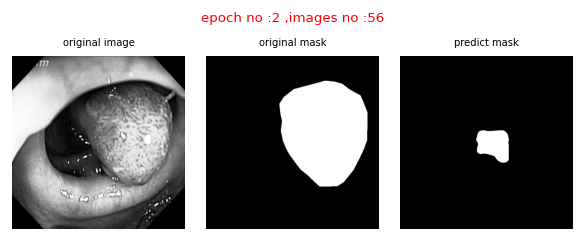

113/113 [==============================] - 84s 693ms/step - loss: 0.3106 - dice_coef_loss: 0.6378 - dice_coef: 0.3622 - jaccard: 0.2225 - val_loss: 0.3657 - val_dice_coef_loss: 0.7944 - val_dice_coef: 0.2056 - val_jaccard: 0.1149
Epoch 3/15
113/113 [==============================] - ETA: 0s - loss: 0.2747 - dice_coef_loss: 0.5418 - dice_coef: 0.4582 - jaccard: 0.3013

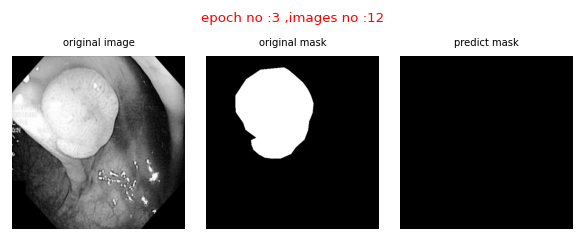

113/113 [==============================] - 87s 696ms/step - loss: 0.2747 - dice_coef_loss: 0.5418 - dice_coef: 0.4582 - jaccard: 0.3013 - val_loss: 0.4178 - val_dice_coef_loss: 0.8598 - val_dice_coef: 0.1402 - val_jaccard: 0.0755
Epoch 4/15
113/113 [==============================] - ETA: 0s - loss: 0.2316 - dice_coef_loss: 0.4475 - dice_coef: 0.5525 - jaccard: 0.3849

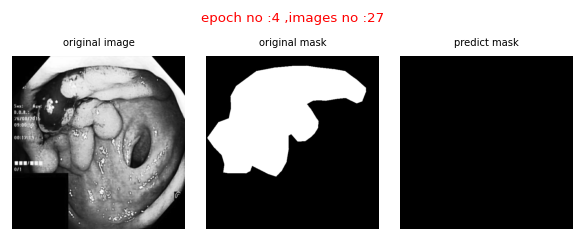

113/113 [==============================] - 86s 710ms/step - loss: 0.2316 - dice_coef_loss: 0.4475 - dice_coef: 0.5525 - jaccard: 0.3849 - val_loss: 0.6049 - val_dice_coef_loss: 0.9604 - val_dice_coef: 0.0396 - val_jaccard: 0.0202
Epoch 5/15
113/113 [==============================] - ETA: 0s - loss: 0.1980 - dice_coef_loss: 0.3806 - dice_coef: 0.6194 - jaccard: 0.4528

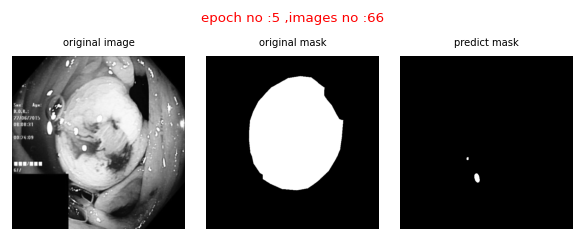

113/113 [==============================] - 87s 701ms/step - loss: 0.1980 - dice_coef_loss: 0.3806 - dice_coef: 0.6194 - jaccard: 0.4528 - val_loss: 0.7113 - val_dice_coef_loss: 0.9215 - val_dice_coef: 0.0785 - val_jaccard: 0.0416
Epoch 6/15
113/113 [==============================] - ETA: 0s - loss: 0.1733 - dice_coef_loss: 0.3325 - dice_coef: 0.6675 - jaccard: 0.5050

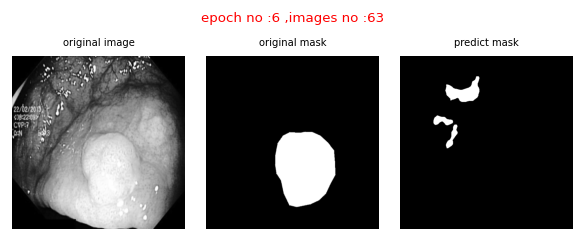

113/113 [==============================] - 84s 697ms/step - loss: 0.1733 - dice_coef_loss: 0.3325 - dice_coef: 0.6675 - jaccard: 0.5050 - val_loss: 0.3014 - val_dice_coef_loss: 0.5890 - val_dice_coef: 0.4110 - val_jaccard: 0.2604
Epoch 7/15
113/113 [==============================] - ETA: 0s - loss: 0.1479 - dice_coef_loss: 0.2860 - dice_coef: 0.7140 - jaccard: 0.5602

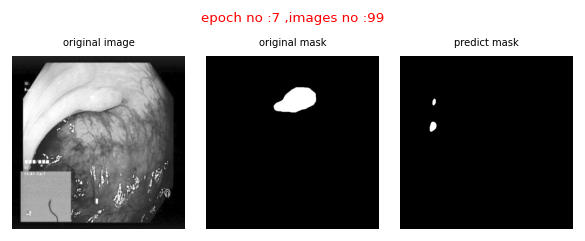

113/113 [==============================] - 88s 709ms/step - loss: 0.1479 - dice_coef_loss: 0.2860 - dice_coef: 0.7140 - jaccard: 0.5602 - val_loss: 0.4859 - val_dice_coef_loss: 0.5924 - val_dice_coef: 0.4076 - val_jaccard: 0.2599
Epoch 8/15
113/113 [==============================] - ETA: 0s - loss: 0.1182 - dice_coef_loss: 0.2255 - dice_coef: 0.7745 - jaccard: 0.6369

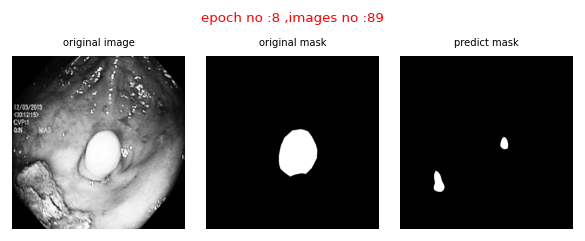

113/113 [==============================] - 84s 697ms/step - loss: 0.1182 - dice_coef_loss: 0.2255 - dice_coef: 0.7745 - jaccard: 0.6369 - val_loss: 0.5894 - val_dice_coef_loss: 0.8619 - val_dice_coef: 0.1381 - val_jaccard: 0.0753
Epoch 9/15
113/113 [==============================] - ETA: 0s - loss: 0.1105 - dice_coef_loss: 0.2139 - dice_coef: 0.7861 - jaccard: 0.6511

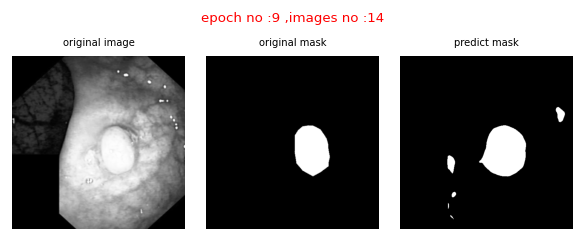

113/113 [==============================] - 85s 698ms/step - loss: 0.1105 - dice_coef_loss: 0.2139 - dice_coef: 0.7861 - jaccard: 0.6511 - val_loss: 0.1709 - val_dice_coef_loss: 0.3137 - val_dice_coef: 0.6863 - val_jaccard: 0.5280
Epoch 10/15
113/113 [==============================] - ETA: 0s - loss: 0.0957 - dice_coef_loss: 0.1827 - dice_coef: 0.8173 - jaccard: 0.6941

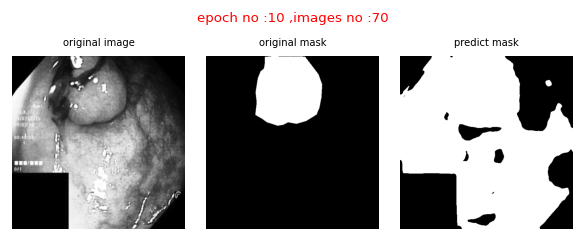

113/113 [==============================] - 87s 716ms/step - loss: 0.0957 - dice_coef_loss: 0.1827 - dice_coef: 0.8173 - jaccard: 0.6941 - val_loss: 0.9798 - val_dice_coef_loss: 0.5441 - val_dice_coef: 0.4559 - val_jaccard: 0.3021
Epoch 11/15
113/113 [==============================] - ETA: 0s - loss: 0.0744 - dice_coef_loss: 0.1442 - dice_coef: 0.8558 - jaccard: 0.7510

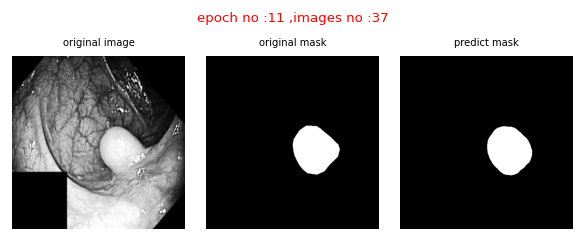

113/113 [==============================] - 86s 711ms/step - loss: 0.0744 - dice_coef_loss: 0.1442 - dice_coef: 0.8558 - jaccard: 0.7510 - val_loss: 0.0885 - val_dice_coef_loss: 0.1634 - val_dice_coef: 0.8366 - val_jaccard: 0.7232
Epoch 12/15
113/113 [==============================] - ETA: 0s - loss: 0.0582 - dice_coef_loss: 0.1115 - dice_coef: 0.8885 - jaccard: 0.8009

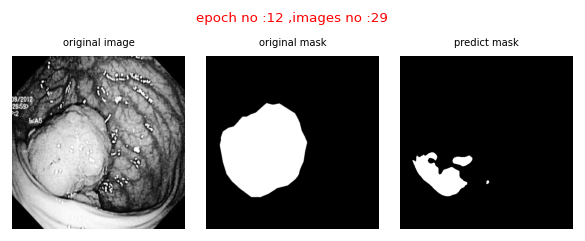

113/113 [==============================] - 87s 706ms/step - loss: 0.0582 - dice_coef_loss: 0.1115 - dice_coef: 0.8885 - jaccard: 0.8009 - val_loss: 0.2540 - val_dice_coef_loss: 0.3399 - val_dice_coef: 0.6601 - val_jaccard: 0.5001
Epoch 13/15
113/113 [==============================] - ETA: 0s - loss: 0.0695 - dice_coef_loss: 0.1356 - dice_coef: 0.8644 - jaccard: 0.7636

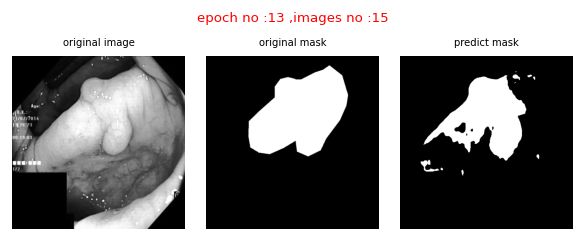

113/113 [==============================] - 84s 698ms/step - loss: 0.0695 - dice_coef_loss: 0.1356 - dice_coef: 0.8644 - jaccard: 0.7636 - val_loss: 0.4387 - val_dice_coef_loss: 0.4413 - val_dice_coef: 0.5587 - val_jaccard: 0.3949
Epoch 14/15
113/113 [==============================] - ETA: 0s - loss: 0.0500 - dice_coef_loss: 0.0976 - dice_coef: 0.9024 - jaccard: 0.8234

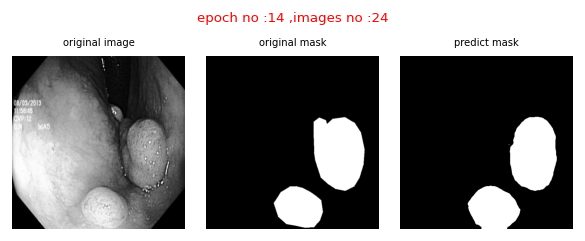

113/113 [==============================] - 89s 714ms/step - loss: 0.0500 - dice_coef_loss: 0.0976 - dice_coef: 0.9024 - jaccard: 0.8234 - val_loss: 0.0812 - val_dice_coef_loss: 0.1577 - val_dice_coef: 0.8423 - val_jaccard: 0.7304
Epoch 15/15
113/113 [==============================] - ETA: 0s - loss: 0.0379 - dice_coef_loss: 0.0733 - dice_coef: 0.9267 - jaccard: 0.8640

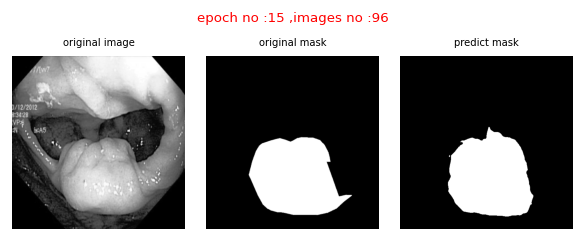

113/113 [==============================] - 86s 712ms/step - loss: 0.0379 - dice_coef_loss: 0.0733 - dice_coef: 0.9267 - jaccard: 0.8640 - val_loss: 0.0499 - val_dice_coef_loss: 0.0986 - val_dice_coef: 0.9014 - val_jaccard: 0.8213


In [23]:
hist = model.fit(train_dataset, batch_size = BATCH_SIZE, epochs = 15, validation_data = validation_dataset, callbacks = my_callbacks)